In [164]:
import logging
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ToTensor, ToPILImage
from torchmetrics import Accuracy, Precision, Recall, Specificity, ROC

from utils.DriveDataset import DriveDataset
from utils.metrics import get_accuracy, get_specificity, get_sensitivity, BinaryConfusionMatrix
from unet import UNet

from tqdm import tqdm

img_dir = Path('./datasets/test/images')
gt_dir = Path('./datasets/test/manual')  # ground truth
out_dir = Path('./datasets/test/predict')
assert os.path.exists(img_dir), "{} does not exist".format(img_dir)
assert os.path.exists(gt_dir), "{} does not exist".format(gt_dir)
assert os.path.exists(out_dir), "{} does not exist".format(out_dir)


In [156]:
test_dataset = DriveDataset(img_dir, gt_dir, scale=1, mask_suffix='_manual1')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=len(test_dataset))
weight_file = './checkpoints/checkpoint_epoch20.pth'
assert os.path.exists(weight_file), "Weight file {} does not exist, " \
                                    "you can download it from ...".format(weight_file)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet(n_channels=3, n_classes=2, bilinear=False)
net.load_state_dict(torch.load(weight_file, map_location=device))

for batch in tqdm(test_loader,
                  total=len(test_loader),
                  desc='Test round', unit='batch', leave=False):
    image = batch['image']  # torch.Size([2, 3, 584, 565]) BCHW
    gt = batch['mask']  # torch.Size([2, 584, 565]) BHW

    with torch.no_grad():
        output = net(image)  # torch.Size([1, 2, 584, 565]) BCHW

prob = output[:, 1, ...]
assert prob.shape == gt.shape

accuracy = Accuracy(threshold=0.0)
precision = Precision(average='micro', threshold=0.0)
recall = Recall(threshold=0.0)
specificity = Specificity(threshold=0.0)
roc = ROC(pos_label=1)

acc = accuracy(prob, gt.bool())
prc = precision(prob, gt.bool())
rcl = recall(prob, gt.bool())
spc = specificity(prob, gt.bool())

print(acc, prc, rcl, spc)

fpr, tpr, thresholds = roc(prob, gt.bool())
print(fpr,'\n', tpr, '\n', thresholds)

D:\software\anaconda\anacondasoftware\envs\torchCPU\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


tensor(0.9576) tensor(0.8628) tensor(0.6137) tensor(0.9906)
tensor([0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]) 
 tensor([0.0000e+00, 1.7303e-06, 3.4605e-06,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00]) 
 tensor([ 7.5485,  6.5485,  6.0871,  ..., -6.2542, -6.2578, -6.2940])


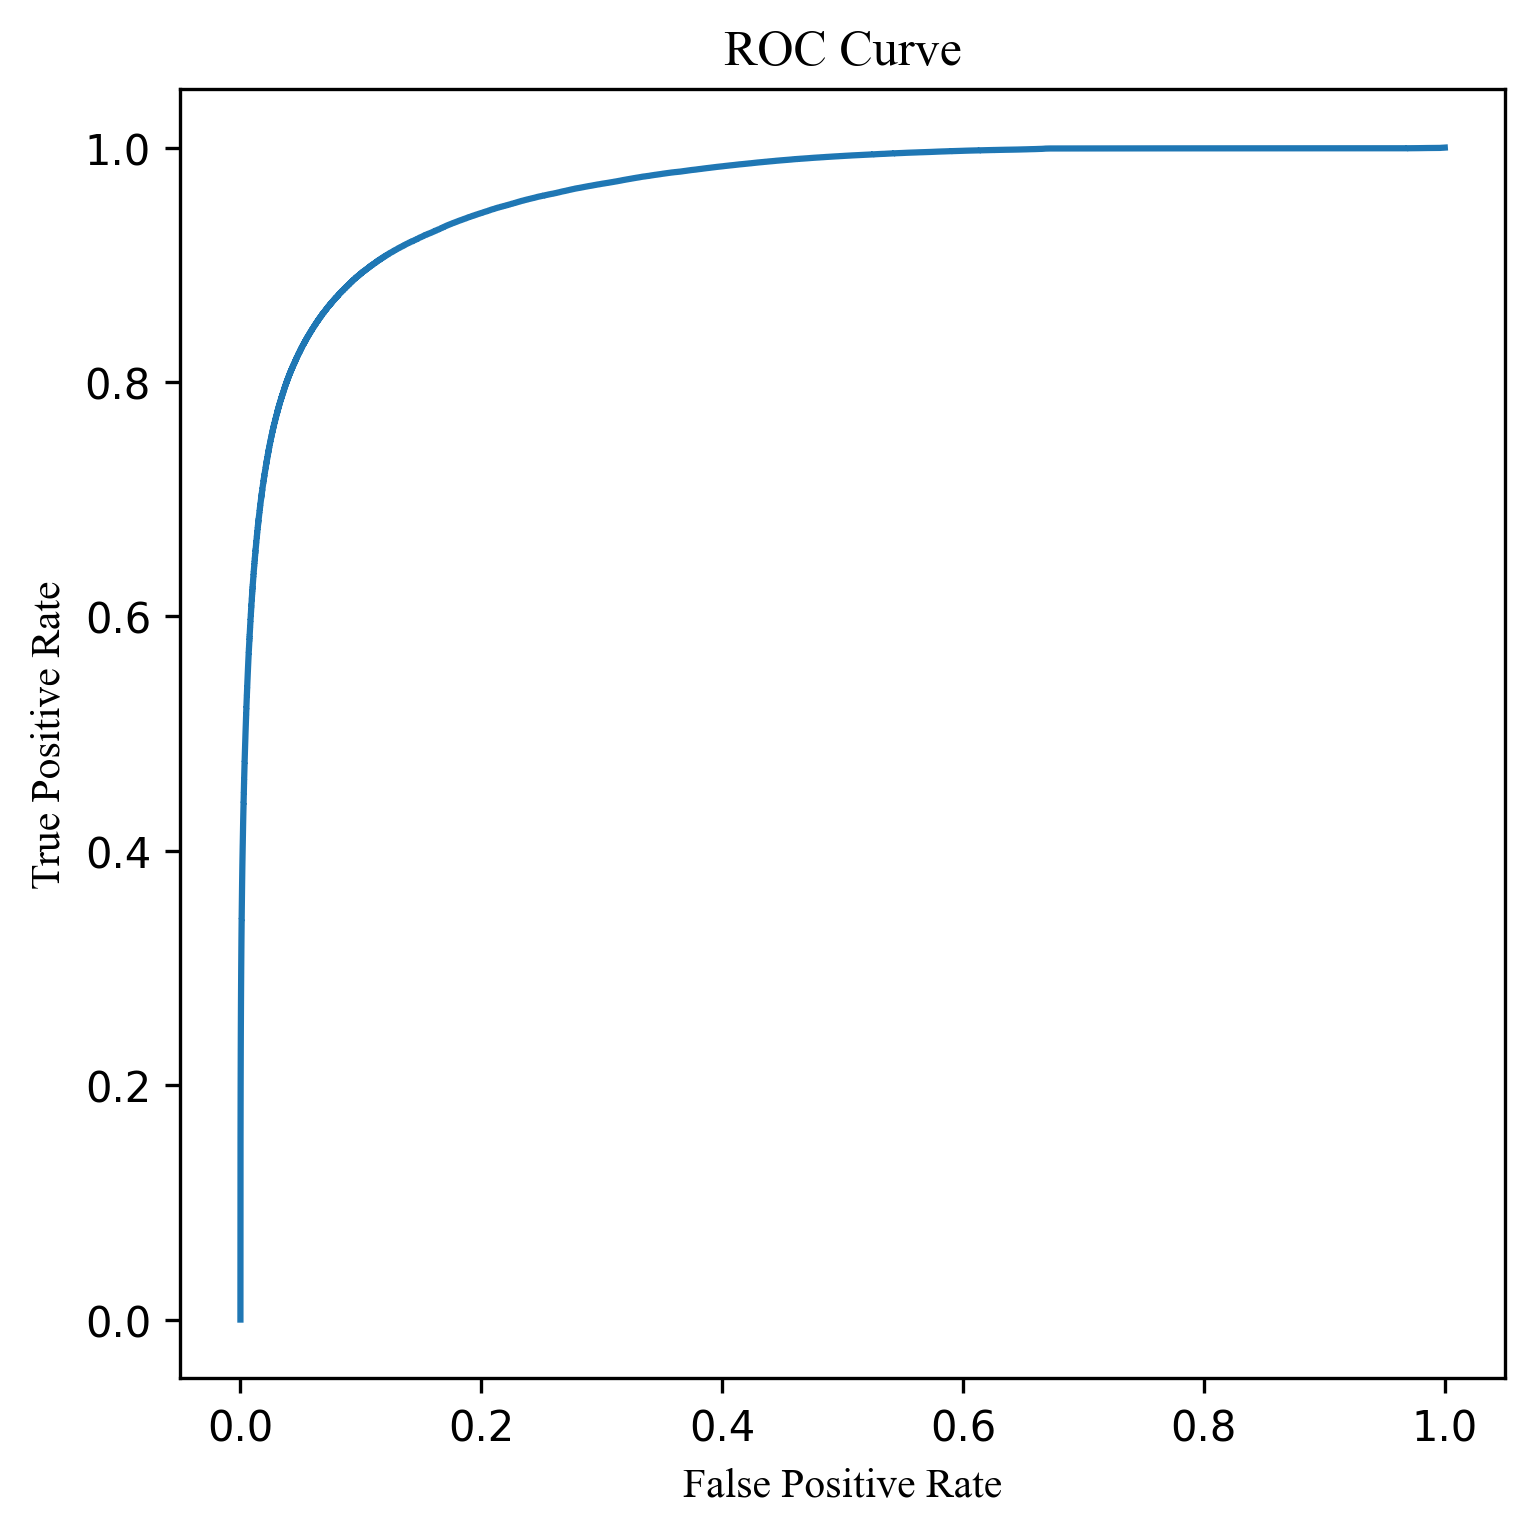

In [157]:
TNRfont = {'fontname':'Times New Roman'}

fig, ax = plt.subplots(figsize=[5,5], dpi=300, layout='constrained')  # a figure with a single Axes
ax.plot(fpr.numpy(), tpr.numpy())
ax.set_xlabel('False Positive Rate', **TNRfont)
ax.set_ylabel('True Positive Rate', **TNRfont)
ax.set_title('ROC Curve', **TNRfont)
# ax.set_ylim(ymin=0, ymax=1)
# ax.set_xlim(xmin=0, xmax=1)
plt.show()

In [170]:
# save output
prob_sigmoid = torch.sigmoid(prob) > 0.5
prob_sigmoid = prob_sigmoid.float()

for i, out in enumerate(prob_sigmoid):
    print(out.shape)

torch.Size([584, 565])
torch.Size([584, 565])
torch.Size([584, 565])
torch.Size([584, 565])
torch.Size([584, 565])
torch.Size([584, 565])
torch.Size([584, 565])
torch.Size([584, 565])
torch.Size([584, 565])
torch.Size([584, 565])
torch.Size([584, 565])
torch.Size([584, 565])
torch.Size([584, 565])
torch.Size([584, 565])
torch.Size([584, 565])
torch.Size([584, 565])
torch.Size([584, 565])
torch.Size([584, 565])
torch.Size([584, 565])
torch.Size([584, 565])


In [171]:
out.shape
pil = ToPILImage()(out)
pil.save('./tttt.gif')